In [1]:
#!/usr/bin/env julia

#   ==========   #
#%% PARAMETERS %%#
#   ==========   #

orbital = "A1"
norbitals = 1 

identityrep = "A1"

# construction and diagonalization in a single step
onestep = true
# use precomputed spin-CG coefficients
spinarray = true
# parallel computation
distributed = parallel = true
# parallel method: distfor or async
method = "distfor"
# discretization ("standard" or "co2005")
discretization = "co2005"
# calculation 
calculation = "IMP"

z = 0.0
if length(ARGS)>0
    # clean/imp
    calculation = "IMP"
    if ARGS[1]=="CLEAN" 
        calculation = "CLEAN"
    end
    # twisting parameter
    if length(ARGS)>1
        z = parse(Float64,ARGS[2])
    end
end

# Free orbital --> Local moment ==> Strong coupling
eps = -0.1
cou =  0.2
gam =  0.01
#gam = 0.0

L = 3.0
betabar = 1.0

cutoff_type = "multiplet" # multiplet/energy
cutoff_magnitude = 200

iterations = 40

spinarray = true  # faster
max_spin2 = 6

distworkers = 6

println( "================" )
println( "SETUP PARAMETERS" )
println( "================" )
@show onestep 
@show distributed 
@show calculation 
@show method 
@show z 
@show eps 
@show cou 
@show gam 
@show L 
@show betabar 
@show cutoff_type 
@show cutoff_magnitude 
@show iterations 
@show spinarray 
@show max_spin2 
@show distworkers

SETUP PARAMETERS
onestep = true
distributed = true
calculation = "IMP"
method = "distfor"
z = 0.0
eps = -0.1
cou = 0.2
gam = 0.01
L = 3.0
betabar = 1.0
cutoff_type = "multiplet"
cutoff_magnitude = 200
iterations = 40
spinarray = true
max_spin2 = 6
distworkers = 6


6

In [2]:
#   =======   #
#%% MODULES %%#
#   =======   #

using Distributed 


using BenchmarkTools 
using DelimitedFiles
using ProfileVega
using Profile

include( "modules/symbols.jl" )
include( "modules/numericals.jl" )
include( "modules/compoundoperators.jl" )
include( "modules/shell.jl" )
include( "modules/thermo.jl" )
include( "modules//spectral.jl" )

if distributed 

    # kill current processes
    for i in workers()
        t = rmprocs(i, waitfor=0)
        wait(t)
    end

    # add requested workers
    if distworkers ≥ nprocs()
        addprocs(distworkers)
    else 
        println( "more workers than processors!" )
    end

    @everywhere begin 
        using ProgressMeter
        using PartialWaveFunctions
        using StaticArrays
        include( "modules/symmetry.jl" )
        include( "modules/diagonalization.jl" )
    end

    println( "DISTRIBUTED CALCULATION WITH $(nworkers()) WORKERS" )

else

    using ProgressMeter
    using PartialWaveFunctions
    using StaticArrays
    include( "modules/symmetry.jl" ) 
    include( "modules/diagonalization.jl" )

    println( "SERIAL CALCULATION" )

end
println()


#   ======================   #
#%% ORBITAL CLEBSCH-GORDAN %%#
#   ======================   #

CG_PATH = "/home/aitor/Bulegoa/ClebschGordan/C4v/cg_symbolic/"
ASYM_PATH = "/home/aitor/Bulegoa/AntiSymmetricPart/C4v/";

ORBITAL_IRREPS = ( "A1" ,)

oirreps = cg_shortcircuit( CG_PATH , ORBITAL_IRREPS... )
oirreps2indices = Dict( o=>i for (i,o) in enumerate(oirreps) )
oirreps2dimensions = Dict( "A1" => 1 ) 
oindex2dimensions = collect( oirreps2dimensions[I] for I in oirreps )

cg_o_full = get_cg_o_fulldict( oirreps , CG_PATH )
cg_o_fullmat = get_cg_o_fullmat( cg_o_full )
cg_o_fullmatint = get_cg_o_fullmatint( cg_o_full , oirreps )


#   ===================   #
#%% SPIN CLEBSCH-GORDAN %%#
#   ===================   #
cg_s_fullmatint = get_cg_s_fullmatint( max_spin2 );

┌ Warning: rmprocs: process 1 not removed
└ @ Distributed /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.6/Distributed/src/cluster.jl:1038


      From worker 5:	WARNING: using LinearAlgebra.I in module Main conflicts with an existing identifier.
      From worker 6:	WARNING: using LinearAlgebra.I in module Main conflicts with an existing identifier.
      From worker 3:	WARNING: using LinearAlgebra.I in module Main conflicts with an existing identifier.
      From worker 2:	WARNING: using LinearAlgebra.I in module Main conflicts with an existing identifier.
      From worker 7:	WARNING: using LinearAlgebra.I in module Main conflicts with an existing identifier.
      From worker 4:	WARNING: using LinearAlgebra.I in module Main conflicts with an existing identifier.
DISTRIBUTED CALCULATION WITH 6 WORKERS




In [3]:
#   ===========================   #
#&& SYMBOLIC CALCULATION OF N=0 &&#
#   ===========================   #

#   ------------ #
#%% state tuples # 
#   ------------ #
a_1 = ( 0 , "a" , 1 )
a_1u = ( a_1... , "u" )
a_1d = ( a_1... , "d" )

tuples_0 = [ a_1u , a_1d ]

#   ----- #
#%% basis #
#   ----- #
hilbert_0 = HilbertSpace( tuples_0... )
basis_0 = CanonicalBasis( hilbert_0 )
println( "HILBERT SPACE" )
println( hilbert_0 )
println()
println( "BASIS" )
println( basis_0 )


#   --------- #
#%% symstates #
#   --------- #
hiztegia = Dict( 
    "a" =>  "A1",
    "u" =>  0.5 ,
    "d" => -0.5
)

symstates_0 = oneirrep_symstates( hilbert_0 , hiztegia , "A1" , "$(ASYM_PATH)A1/" )
symstates_0_new = Dict()
for (q,s) in symstates_0 
    push!( symstates_0_new , (q[1:5]...,1)=>s ) 
end
symstates_0 = symstates_0_new
println( "SYMSTATES" )
print_dict( symstates_0 )

multiplets_0 = get_multiplets( symstates_0 )

irrepsubs_0 = get_multiplets( symstates_0 )
println( "MULTIPLETS" )
for m in irrepsubs_0 
    println( m )
end
println()

#   --------- #
#%% operators #
#   --------- #
epsilon_symparams = Dict( 
    "A1" => eps
)
epsilon = epsilon_sym( symstates_0 , epsilon_symparams ; verbose=false )
println( "EPSILON OPERATOR" )
print_diagonals( epsilon )

u_symparams = Dict( 
    ("A1",0) => [cou][:,:]
)
coulomb = u_sym( symstates_0 , u_symparams ; verbose=false );
println( "COULOMB OPERATOR" )
print_diagonals( coulomb )


#   ---------------- #
#%% full hamiltonian #
#   ---------------- #
H = epsilon + coulomb 
# α = ϵ_0^z (scaling factor)
if discretization=="standard"
    global α = 0.5 * L^z * (1+L^-1)
elseif discretization=="co2005"
    global α = compute_ebar0_z(z,L;discretization=discretization)
end
H.matrix ./= α
gam = sqrt(2.0*gam/pi) / α # for later
#gam /= α

HILBERT SPACE
(0, "a", 1, "u")
(0, "a", 1, "d")

BASIS
1: |)
2: | 0 a 1 u )
3: | 0 a 1 d )
4: | 0 a 1 u , 0 a 1 d )
SYMSTATES
(1, "A1", 0.5, 1, 0.5, 1)
(1.0 + 0.0im) | 0 a 1 u )

(0, "A1", 0, 1, 0, 1)
(1.0 + 0.0im) |)

(2, "A1", 0, 1, 0, 1)
(1.0 + 0.0im) | 0 a 1 u , 0 a 1 d )

(1, "A1", 0.5, 1, -0.5, 1)
(1.0 + 0.0im) | 0 a 1 d )

MULTIPLETS
(0, "A1", 0.0, 1)
(1, "A1", 0.5, 1)
(2, "A1", 0.0, 1)

EPSILON OPERATOR
|)
0.0 + 0.0im

| 0 a 1 u )
-0.1 + 0.0im

| 0 a 1 d )
-0.1 + 0.0im

| 0 a 1 u , 0 a 1 d )
-0.2 + 0.0im

COULOMB OPERATOR
|)
0.0 + 0.0im

| 0 a 1 u )
0.0 + 0.0im

| 0 a 1 d )
0.0 + 0.0im

| 0 a 1 u , 0 a 1 d )
0.2 + 0.0im



0.1314915474125499311286069383916820064110100966207407132983265861609883585973612

In [4]:
#   ================================================   #
#&& NUMERICAL ADDITION OF INNERMOST CONDUCTION SHELL &&#
#   ================================================   #

#   -----   #
#%% irreu %%#
#   -----   #
# imp
if calculation=="IMP"
    irreps_0 = get_irreps( symstates_0 )
    irrEU_imp = symdiag( irreps_0 , symstates_0 , H )
    normalize_irrEU( irrEU_imp )
    println( "irrEU for IMP" )
    print_dict( irrEU_imp )
    println()
# clean
elseif calculation=="CLEAN"
    irrEU_clean = get_irrEU_clean( "A1g" )
    normalize_irrEU( irrEU_clean )
    println( "irrEU for CLEAN" )
    print_dict( irrEU_clean )
    println()
end


#   ---------------   #
#%% combinations u' %%#
#   ---------------   #
combinations_uprima = 
    Dict{ Tuple{Int64,Int64,Int64,Int64} , NTuple{2,Tuple{Int64,Int64,Int64,Int64}} }()
m_vac = (0,oirreps2indices["A1"],0,1)
#print( "COMBINATIONS U' " )
if calculation=="IMP"
    #println( "for IMP" )
    for m_mu in multiplets_0
        mint_mu = convert_to_int( m_mu , oirreps2indices )
        push!( combinations_uprima , mint_mu=>(mint_mu,m_vac) )
    end 
elseif calculation=="CLEAN" 
    #println( "for CLEAN" )
    push!( combinations_uprima , m_vac=>(m_vac,m_vac) )
end

irreps_uprima = Set( k[1:3] for k in keys(combinations_uprima) )
combinations_uprima = 
        Dict{ NTuple{3,Int64} , Vector{NTuple{3,NTuple{4,Int64}}} }(
            G => NTuple{3,NTuple{4,Int64}}[
                (m_u,m_mu,m_i)
                for (m_u,(m_mu,m_i)) in combinations_uprima 
                if m_u[1:3]==G
                ]
            for G in irreps_uprima
        ) 
println( "COMBINATIONS U' FOR N=0" )
for (G,combs) in combinations_uprima
    println( "$G => $combs" )
end
println()

#   ----------------------   #
#%% pseudo-CG coefficients %%#
#   ----------------------   #
pcg = get_pseudoCG( symstates_0 , 
                    basis_0 , 
                    hiztegia , 
                    oirreps2indices )
println( "PCG" )
print_dict( pcg ) 
println()

# PCG matrix in int format
irrmult_0 = get_irreps( multiplets_0 ; multiplicity=true )
pcgmat = get_pseudoCG_mat( pcg , 
                           irrmult_0 , 
                           oindex2dimensions , 
                           oirreps2indices );

#   -------------------   #
#%% shell cops and qq_a %%#
#   -------------------   #
shell_cops = shell_coperators( basis_0 , hiztegia )
qq_a = collect( convert_to_int(q_a,oirreps2indices) 
                for q_a in keys(shell_cops) )
println( "ONE-PARTICLE HOPPERS" )
@show qq_a;



#   -----------------   #
#%% hopping parameter %%#
#   -----------------   #
hop = Dict( 
    (oirreps2indices["A1"],1) => ComplexF64(gam) 
)
println( "ATOM-SHELL HOPPING PARAMETER" )
@show hop
println()
println()

#   --------------------------   #
#%% block and shell multiplets %%#
#   --------------------------   #
if calculation=="IMP"
    symstates_block = symstates_0 
    multiplets_block = get_multiplets( symstates_block )
    global irrEU = Dict( (convert_to_int(G,oirreps2indices),(E,U))
                   for (G,(E,U)) in irrEU_imp )
    println( "irrEU before adding first shell (to IMP)" )
    for (G,(E,U)) in irrEU 
        @show G, E
    end
    println()
elseif calculation=="CLEAN"
    multiplets_block = Set([(0,"A1",0.0,1)])
    global irrEU = Dict( (convert_to_int(G,oirreps2indices),(E,U))
                   for (G,(E,U)) in irrEU_clean )
    println( "irrEU before adding first shell (to CLEAN)" )
end 
symstates_shell  = symstates_0 
multiplets_shell = multiplets_0

multiplets_block = Set( convert_to_int(m,oirreps2indices) 
                        for m in multiplets_block )
multiplets_shell = Set( convert_to_int(m,oirreps2indices)
                        for m in multiplets_shell )

#   -----------------   #
#%% excitation matrix %%#
#   -----------------   #
#M = get_M0( pcg , qq_a )
#println( "===================" )
#println( "M excitation matrix" )
#println( "===================" )
#print_dict( M )
#println()
#println( "M size: $(length(collect(keys(M[qq_a[1]]))))" )
#AA = [get_A(M,irrEU)]

Mred = get_redmat( pcg ,
                   multiplets_block ,
                   cg_o_fullmatint ,
                   cg_s_fullmatint ;
                   verbose=true)
println( "M reduced" )
print_dict( Mred )

ρ = partition( irrEU, betabar, oindex2dimensions )

irrEU = normalize_irrEU( irrEU )
@show irrEU


multiplets_a = collect( m for m in multiplets_block if m[1]==1 )
A = redM2A( Mred,
            multiplets_a,
            cg_o_fullmatint,
            cg_s_fullmatint,
            irrEU,
            ρ,
            verbose=true)
@show A
AA = [A]


#   ------------------------   #
#%% impurity quantum numbers %%#
#   ------------------------   #
println("IMPURITY MULTIPLET SPACE")
omults = ordered_multiplets(multiplets_block)
mult2index = Dict( m=>i for (i,m) in 
                   enumerate(omults))
mm_i = Dict( 
            m=>[(i==mult2index[m] ? 1.0 : 0.0)
                for i in 1:length(multiplets_block)] 
                for m in omults
           )
@show mm_i 
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )
println()

#   ---------------------------------------   #
#%% matrix construction and diagonalization %%#
#   ---------------------------------------   #
if distributed && onestep
    @time begin
    global (irrEU,combinations_uprima) = matdiag_distributed_mat( 
                multiplets_block , 
                multiplets_shell ,
                irrEU , 
                hop , 
                cg_o_fullmatint , 
                cg_s_fullmatint ,
                pcg , 
                pcgmat, 
                qq_a , 
                combinations_uprima , 
                oindex2dimensions ;
                verbose=false );
    end
else
    @time begin
    global (irrEU,combinations_uprima) = matdiag_serial_mat( 
                multiplets_block , 
                multiplets_shell ,
                irrEU , 
                hop , 
                cg_o_fullmatint , 
                cg_s_fullmatint ,
                pcg , 
                pcgmat, 
                qq_a , 
                combinations_uprima , 
                oindex2dimensions ;
                verbose=false );
    end
end
minE = minimum([e for (E,U) in values(irrEU) for e in E])
irrEU = Dict( G=>(E.-minE,U) for (G,(E,U)) in irrEU )
energies = sort([e for (E,U) in values(irrEU) for e in E])
@show energies
@show length(energies)

mm_i = imp_mults( irrEU ,
                  oindex2dimensions ,
                  combinations_uprima ,
                  mm_i )
@show mm_i
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )


#   ~~~~~~~~~~~~~~~~~~~   #
#%% transformation of M %%#
#   ~~~~~~~~~~~~~~~~~~~   #
@show combinations_uprima

#println( "===================" )
#println( "TRANSFORMATION OF M" )
#println( "===================" )
#println()
#q_a = qq_a[1]
#M = get_new_M( M , 
#               qq_a , 
#               irrEU , 
#               oindex2dimensions , 
#               combinations_uprima ,
#               cg_o_fullmatint , 
#               cg_s_fullmatint ;
#               verbose=true )
#println( "M matrix" )
#print_dict( M )
#println()
#println( "M size: $(length(collect(keys(M[qq_a[1]]))))" )
#
#push!( AA , get_A(M,irrEU) )


Mred = get_new_blockredmat( 
            Mred , 
            irrEU ,
            combinations_uprima ,
            multiplets_a ,
            cg_o_fullmatint ,
            cg_s_fullmatint )

ρ = partition( irrEU, betabar, oindex2dimensions )
push!( AA , redM2A(Mred,multiplets_a,cg_o_fullmatint,cg_s_fullmatint,irrEU,ρ,verbose=true) )

@show Mred


irrEU for IMP
(1, "A1", 0.5)
([-0.16480021530964023], ComplexF64[1.0 + 0.0im])

(0, "A1", 0.0)
([0.0], ComplexF64[1.0 + 0.0im])

(2, "A1", 0.0)
([0.0], ComplexF64[1.0 + 0.0im])


COMBINATIONS U' FOR N=0
(1, 1, 1) => [((1, 1, 1, 1), (1, 1, 1, 1), (0, 1, 0, 1))]
(0, 1, 0) => [((0, 1, 0, 1), (0, 1, 0, 1), (0, 1, 0, 1))]
(2, 1, 0) => [((2, 1, 0, 1), (2, 1, 0, 1), (0, 1, 0, 1))]

PCG
((2, 1, 0, 1, 0, 1), (1, 1, 1, 1, -1, 1), (1, 1, 1, 1, 1, 1))
-1.0 + 0.0im

((2, 1, 0, 1, 0, 1), (1, 1, 1, 1, 1, 1), (1, 1, 1, 1, -1, 1))
1.0 + 0.0im

((1, 1, 1, 1, -1, 1), (1, 1, 1, 1, -1, 1), (0, 1, 0, 1, 0, 1))
1.0 + 0.0im

((1, 1, 1, 1, 1, 1), (1, 1, 1, 1, 1, 1), (0, 1, 0, 1, 0, 1))
1.0 + 0.0im


ONE-PARTICLE HOPPERS
qq_a = [(1, 1, 1, 1, -1, 1), (1, 1, 1, 1, 1, 1)]
ATOM-SHELL HOPPING PARAMETER
hop = Dict{Tuple{Int64, Int64}, ComplexF64}((1, 1) => 0.13149154741254993 + 0.0im)


irrEU before adding first shell (to IMP)
(G, E) = ((1, 1, 1), [-0.16480021530964023])
(G, E) = ((0, 1, 0), [0.0])
(G, E) = ((2, 1, 0

Dict{Tuple{Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}, Tuple{Int64, Int64, Int64}}, Array{ComplexF64, 3}} with 6 entries:
  ((1, 1, 1), (1, 1, 1), (0, 1, 0)) => [-0.874931+0.0im; 0.484248+0.0im]
  ((3, 1, 1), (1, 1, 1), (2, 1, 0)) => [0.642229+0.0im; 0.295874+0.0im]…
  ((2, 1, 0), (1, 1, 1), (1, 1, 1)) => [0.90825+0.0im; 0.874931+0.0im; -0.41842…
  ((3, 1, 1), (1, 1, 1), (2, 1, 2)) => [0.59308+0.0im; 1.07157+0.0im]
  ((4, 1, 0), (1, 1, 1), (3, 1, 1)) => [-1.23734+0.0im]…
  ((2, 1, 2), (1, 1, 1), (1, 1, 1)) => [-0.484248+0.0im]…

In [5]:
#   =============   #
#%% NRG PROCEDURE %%#
#   =============   #
hopchannels = collect(keys( hop ))
@profile nrg = NRG_mat_spectral_redM( 
           iterations , 
           cutoff_type , 
           cutoff_magnitude , 
           L , 
           hopchannels , 
           irrEU , 
           multiplets_shell ,
           cg_o_fullmatint , 
           pcg ,
           pcgmat ,
           qq_a ,
           combinations_uprima ,
           betabar ,
           oindex2dimensions ,
           mm_i ,
           Mred ,
           AA ;
           spinarray=true ,
           cg_s_fullmatint=cg_s_fullmatint ,
           distributed=distributed ,
           z=z );
println()

NRG PROCEDURE

ITERATION n=2
Applying cutoff to obtain block multiplets...   0.000014 seconds (49 allocations: 5.781 KiB)
10 multiplets kept (16 states), 0 multiplets discarded
proportion: 100.0%. max energy: 0.5511801371795371. max spin: 2
Renormalizing eigenvalues...
shell hopping = 0.8320502943378437292155823211861303723131191531353746571344014239826023017835695
Diagonalizing Hamiltonian...
(ppp.time, ppp.bytes * 10 ^ -6, ppp.gctime) = (0.055173836, 4.727112000000002, 0.0)
m_imp = [0.21600377423000391, 0.5679924515399922, 0.216003774230004]
THERMODYNAMICS
t = 0.6666666666666666
ρ = 14.53753951626048
entr = 2.676734236070528
mag = 0.35103726441353617
N = 0.4013932581354568
en = 1.1323958615759482

~~~~~~~~~~~~~~~~~~
COMPUTING A MATRIX
~~~~~~~~~~~~~~~~~~

ground multiplet: (3, 1, 1)

iterating over reduced matrix...

((3, 1, 1), (1, 1, 1), (2, 1, 2)) ==> positive sector

(m_u, m_a, m_v) = ((3, 1, 1, 1), (1, 1, 1, 1), (2, 1, 2, 1))
w = 0.06180323430721711
(m_u, m_a, m_v) = ((3, 1, 1, 1

Excessive output truncated after 524291 bytes.


COMPUTING A MATRIX
~~~~~~~~~~~~~~~~~~

ground multiplet: (28, 1, 0)

iterating over reduced matrix...

((29, 1, 5), (1, 1, 1), (28, 1, 0)) ==> negative sector

((28, 1, 0), (1, 1, 1), (27, 1, 1)) ==> positive sector

(m_u, m_a, m_v) = ((28, 1, 0, 1), (1, 1, 1, 1), (27, 1, 1, 1))
w = 2.281462987816974e-5
(m_u, m_a, m_v) = ((28, 1, 0, 1), (1, 1, 1, 1), (27, 1, 1, 2))
w = 4.375475373932456e-11
(m_u, m_a, m_v) = ((28, 1, 0, 1), (1, 1, 1, 1), (27, 1, 1, 3))
w = 

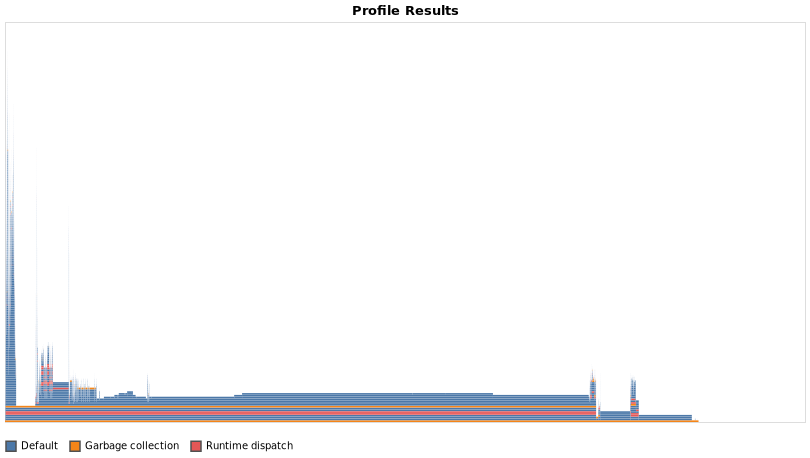

In [6]:
ProfileVega.view()

# ########################## #
# COMPUTING SPECTRAL FUNCION #
# ########################## #

α = 0.6067953237325070485825370907773047327383544731024712582794126521655369649388884
ω = 1.0
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.9465508226401592
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.8959584598407622
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.8480702172136836
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.8027415617602307
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.7598356856515925
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.7192230933248643
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.6807812106484503
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.6443940149772543
omega is in interval 3: [0.35033344349996903,1.0510003304999072]
ω = 0.6099516849811151
omega is in interval

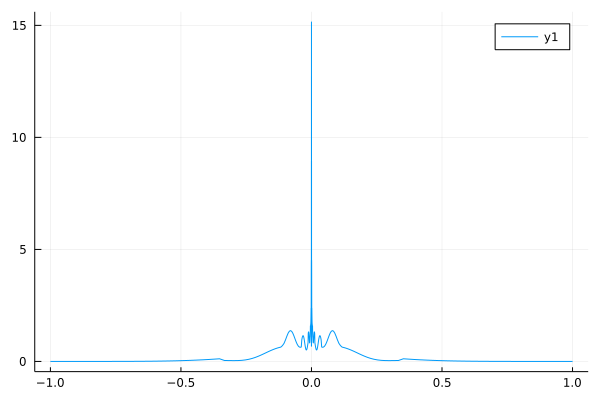

In [7]:
#   ~~~~~~~~~~~~~~~~~   #
#%% SPECTRAL FUNCTION %%#
#   ~~~~~~~~~~~~~~~~~   #

println( "# ########################## #" )
println( "# COMPUTING SPECTRAL FUNCION #" )
println( "# ########################## #" )
println()

function is_in_interval( omega , emin , emax ) 
    return (omega>emin && omega<emax)
end

@show α

widthfac = L
etafac = 0.7
q_a = qq_a[1]
omegas = [sign*L^(-(x-2)/2.0) for sign in [-1.0,1.0] for x in 2:0.1:(iterations-2)]
#omegas = collect(-1.0:0.1:1.0)
spectral = [0.0 for o in omegas]
sort!( omegas )

alternation = "even"
alternation=="even" && (Ninit=3)
alternation=="odd" && (Ninit=2)

for (i,o) in enumerate(omegas)

    omega = -o

    println( "ω = $omega" )

    for N in Ninit:2:iterations 
        omegaN = Float64(α * L^(-(N-2)/2.0) )
        emin   = omegaN#/widthfac
        #emax  = omegaN*nrg.maxes[N-1]
        emax   = omegaN*widthfac
        local A      = AA[N]
        eta    = etafac*omegaN

        #positive interval 
        if is_in_interval( omega , emin , emax )
            println( "omega is in interval $(N): [$emin,$emax]" )
            for (m,(e,coeffs)) in A
                Δ = (omega-e*omegaN)
                c = coeffs[2]*
                    P(Δ,etafac*omegaN)
                spectral[i] += coeffs[2]*
                               P(Δ,eta)
            end
        end

        # negative interval 
        if is_in_interval( omega , -emax , -emin )
            println( "omega is in interval $(N): [$(-emax),$(-emin)]" )
            for (m,(e,coeffs)) in A
                Δ = omega+e*omegaN
                c = coeffs[2]*
                    P(Δ,eta)
                spectral[i] += coeffs[1] *
                               P(Δ,eta)
            end
            println()
        end

    end
end
#for (i,o) in enumerate(omegas)
#    o>0 && (omegas[i]=log(o))
#    o<0 && (omegas[i]=-log(-o))
#end
writedlm( "spectral/spectral.dat" , [omegas spectral] )

using Plots
plot( omegas , spectral )

